In [360]:
balance_names = []

In [530]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk
tf.random.set_seed(42)

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

In [531]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [532]:
reduction = 1

img_width = int(8/reduction)
img_height = int(600/reduction)

In [533]:
image_names = []
path = pathlib.Path(r'O:\eve_models\training_data\route_y')
for data in glob.glob(f"{path}\*.png"):
    file = data.split('\\')[-1:][0]
    image_names.append(file)

In [534]:
random.shuffle(image_names)

In [535]:
image_data = {}
f = open(f"{path}\\boxes.json")
image_data_raw = json.load(f)
f.close()

for data in image_data_raw:
    image_data[data['image_name']] = data['bbox'][1:2]
image_data[list(image_data.keys())[0]]

[377]

In [536]:
def convert_to_baw(img, thresh=80):
    fn = lambda x: 255 if x > thresh else 0
    return img.convert('L').point(fn, mode='1')

In [537]:
train_names, val_names, test_names = np.split(image_names, [int(len(image_names)*0.8), int(len(image_names)*0.9)])

In [538]:
train_x = []
for image_name in tqdm(train_names):
    try:
        img = Image.open(f"{path}\\{image_name}")
        #img = convert_to_baw(img)
        img = img.crop((132, 0, 140, 600))
        if reduction != 1:
            img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
        train_x.append(np.array(img))
    except:
        print(f"{path}\\{image_name}")
    
val_x = []
for image_name in tqdm(val_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    img = img.crop((132, 0, 140, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    val_x.append(np.array(img))
    
test_x = []
for image_name in tqdm(test_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    img = img.crop((132, 0, 140, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    test_x.append(np.array(img))

100%|███████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 260.52it/s]


In [539]:
len(train_x)

1392

In [540]:
train_x[0].shape

(600, 8, 3)

In [541]:
train_y = []
for image_name in tqdm(train_names):
    train_y.append(image_data[image_name][0])
    
val_y = []
for image_name in tqdm(val_names):
    val_y.append(image_data[image_name][0])
    
test_y = []
for image_name in tqdm(test_names):
    test_y.append(image_data[image_name][0])

100%|████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<?, ?it/s]


In [542]:
len(train_x)

1392

In [543]:
train_x[0].shape

(600, 8, 3)

In [544]:
len(train_y)

1392

In [545]:
train_y[0]

344

In [546]:
augmentations = 10
aug_range_y = [-60, 80]

#balance_names = []

train_alter_x = []
train_alter_y = []
train_alter_names = []
for i in range(len(train_x)):
    true_aug = 0
    if train_names[i] in balance_names:
        true_aug = augmentations * (balance_names.count(train_names[i]) * 5)
        
    for a in range(true_aug):
        img = Image.fromarray(train_x[i])
        x_pixels = 0  
        y_pixels = random.randint(*aug_range_y)
        translated_img = img.transform(img.size, Image.AFFINE, (1, 0, x_pixels, 0, 1, y_pixels))
        train_alter_x.append(np.array(translated_img))

        train_alter_y.append(train_y[i] - y_pixels)
        train_alter_names.append(train_names[i])

train_x = train_x + train_alter_x
train_y = train_y + train_alter_y
train_names = np.array(list(train_names) + train_alter_names)

In [547]:
train_y[0]

344

In [548]:
train_y[-1]

288

In [549]:
len(train_x)

109092

In [550]:
train_x[0].shape

(600, 8, 3)

In [551]:
len(train_y)

109092

In [552]:
len(train_alter_y)

107700

In [553]:
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

train_y = np.array(train_y) / np.array([1000])
val_y = np.array(val_y) / np.array([1000])
test_y = np.array(test_y) / np.array([1000])

In [554]:
train_y[0]

0.344

In [555]:
train_y[-1]

0.288

In [556]:
train_x[30].shape

(600, 8, 3)

<Axes: ylabel='Count'>

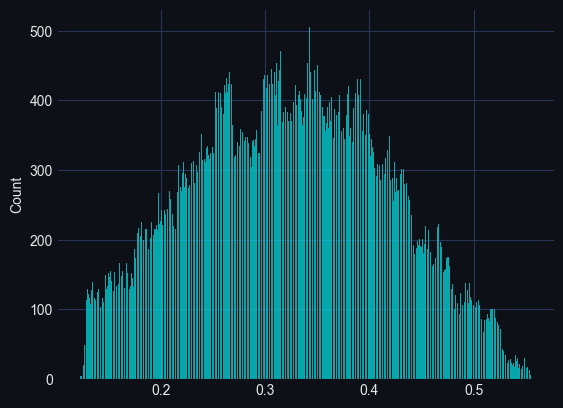

In [557]:
import seaborn as sns
sns.histplot(train_y, bins=600)

In [558]:
len(train_x)

109092

In [559]:
# measures of dispersion
min_ = np.amin(train_y)
max_ = np.amax(train_y)
range_ = np.ptp(train_y)
variance = np.var(train_y)
sd = np.std(train_y)
 
#print("Array =", train_y)
print("Measures of Dispersion")
print("Minimum =", min_)
print("Maximum =", max_)
print("Range =", range_)
print("Variance =", variance)
print("Standard Deviation =", sd)

Measures of Dispersion
Minimum = 0.123
Maximum = 0.555
Range = 0.43200000000000005
Variance = 0.008821218933596057
Standard Deviation = 0.09392134439836376


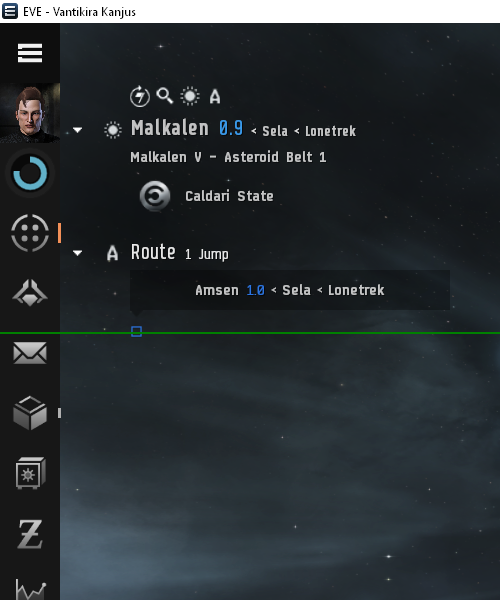

In [560]:
index = 20
img = Image.open(f"{path}\\{train_names[index]}")
truth = (train_y[index] * np.array([1000])) # reduction
img1 = ImageDraw.Draw(img)  
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img

In [562]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    #layers.Resizing(img_height, img_width, interpolation='bilinear', crop_to_aspect_ratio=False),
    #layers.Normalization(input_shape=(img_height, img_width, 3)),
    #vgg,
    #layers.GlobalAveragePooling2D(),
    layers.Conv2D(4, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Conv2D(8, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(16, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.SpatialDropout2D(0.2),
    #layers.GlobalAvgPool2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(64, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(128, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(256, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(512, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.MaxPooling2D(2),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.MaxPooling2D(2),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #layers.Dense(units=512, activation='relu'),
    #layers.Dense(units=256, activation='relu'),
    #layers.Dense(units=128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(units=64, activation='relu'),
    #layers.Dropout(0.1),
    #layers.Dense(units=32, activation="relu"),
    #layers.Dense(units=32, activation="relu"),
    layers.Dense(units=32, activation="relu"),
    #layers.Dropout(0.1),
    layers.Dense(units=1)  
])


epochs = 100
lr = 1e-3

callbacks = [
    ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.1, patience=5, min_lr=1e-10, verbose=1),
    #lr_finder,
    EarlyStopping(monitor='val_root_mean_squared_error', patience=20, restore_best_weights=False),
]

#model.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.mae, metrics=['accuracy', 'mse', 'mae'])
model.compile(optimizer=Adam(lr), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.losses.MeanSquaredError()])

history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=512,
    shuffle=True,
    epochs=epochs,
    callbacks=callbacks
)



Epoch 1/100
214/214 [==============================] - 2s 6ms/step - loss: 0.0301 - root_mean_squared_error: 0.1734 - mean_squared_error: 0.0300 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387 - val_mean_squared_error: 0.0015 - lr: 0.0010
Epoch 2/100
214/214 [==============================] - 1s 6ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - mean_squared_error: 0.0018 - val_loss: 6.9193e-04 - val_root_mean_squared_error: 0.0263 - val_mean_squared_error: 6.9193e-04 - lr: 0.0010
Epoch 3/100
214/214 [==============================] - 1s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - mean_squared_error: 0.0011 - val_loss: 5.4049e-04 - val_root_mean_squared_error: 0.0232 - val_mean_squared_error: 5.4049e-04 - lr: 0.0010
Epoch 4/100
214/214 [==============================] - 1s 6ms/step - loss: 8.3000e-04 - root_mean_squared_error: 0.0288 - mean_squared_error: 8.3073e-04 - val_loss: 5.2761e-04 - val_root_mean_squared_error: 0.0230 - val_mean_squared_error: 

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
test_image_index = 4

prediction = model.predict(np.array([test_x[test_image_index]]))
result = ((prediction) * np.array([1000])) # reduction
result = result[0]
print(result)
truth = (test_y[test_image_index] * np.array([1000])) # reduction
print(truth)

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.open(f"{path}\\{test_names[test_image_index]}")
img1 = ImageDraw.Draw(img)  
#img1.ellipse((result[0]-10,result[1]-10,result[0]+10,result[1]+10), outline ="red", width=5)
#img1.ellipse((truth[0]-10,truth[1]-10,truth[0]+10,truth[1]+10), outline ="Green", width=5)
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img1.line([(0,result[0]),(500,result[0])], fill ="Red", width=2)
img1.line([(136,0),(136,600)], fill ="Red", width=2)


img

In [ ]:
model.save('test_location.h5')

In [ ]:
from tensorflow.keras import backend as K
predictions = model.predict(train_x)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
rmses = []
for i in range(len(train_x)):
    
    rmse = root_mean_squared_error(train_y[i], predictions[i]).numpy()
    rmses.append(rmse)




test_image_index = np.argmax(rmses)
print(f"Worst RMSE:{rmses[test_image_index]}")

prediction = model.predict(np.array([train_x[test_image_index]]))
result = ((prediction) * np.array([1000])) # reduction
result = result[0]
print(result)
truth = (train_y[test_image_index] * np.array([1000])) # reduction
print(truth)

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.fromarray(train_x[test_image_index])
img1 = ImageDraw.Draw(img)  
#img1.ellipse((result[0]-10,result[1]-10,result[0]+10,result[1]+10), outline ="red", width=5)
#img1.ellipse((truth[0]-10,truth[1]-10,truth[0]+10,truth[1]+10), outline ="Green", width=5)
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img1.line([(0,result[0]),(500,result[0])], fill ="Red", width=2)
img1.line([(136,0),(136,600)], fill ="Red", width=2)


img


In [ ]:
for i in range(len(rmses)):
    if rmses[i] > 0.01:
        balance_names.append(train_names[i])

In [ ]:
len(balance_names)